# Connect4 DQN model
By LaughingSkull 
as new RL agent for my game COnnect-4: https://www.laughingskull.org/Games/Connect4/Connect4.php


## DQN (Deep Q-Network)

* A value-based reinforcement learning method.
* Uses a neural network to approximate the Q-function: estimates the expected future rewards for taking actions in given states.
* Learns via Q-learning: updates the Q-values using the Bellman equation.
* Typically uses techniques like experience replay and target networks to stabilize training.

### version log    

* 0.8.0 - start with new convolutional part<br>
    * keeping L2 regularization
* 0.9.0 - extension to shallow training
* 0.10.0 - extension to L3 training
    * NO PRUNE:
        * worse 
    * SHARPer PRUNE
    * extend phases
        * MixedR12: no improvement; &cross;
        * Shallow
        * Fixed2
        * Variable23
        * Variable3
* 0.11.0 - recover fixed 2
    * corrected reward leaking bug
    * corrected draw bug
* 0.12.0 refactoring and restarting
* 0.13 restarting again
    * strategy weights djustment
* 0.14 new restart from scratch
    * intermediate phases
* 0.15 shaped rewards
* 0.16 testing target_update_interval

## Links, learning from
[https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
<br>
[https://pettingzoo.farama.org/tutorials/agilerl/DQN/](https://pettingzoo.farama.org/tutorials/agilerl/DQN/)
<br>
### Other helpful links

<br>[https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967](https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967)
<br>[https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.](https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.)
<br>[https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041](https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041)
<br>[https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.)
<br>
[https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68](https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68)
<br>
[https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html](https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html)
<br>



## Import dependecies and recheck installation

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pprint;
import pandas as pd
import os
import json
from IPython.display import display, clear_output

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU.")


All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ["PYTHONHASHSEED"] = str(SEED)

## Custom imports

In [3]:
from C4.connect4_env import Connect4Env
from C4.connect4_lookahead import Connect4Lookahead
from DQN.training_phases_config import TRAINING_PHASES
from DQN.opponent_action import get_opponent_action
from DQN.DQN_replay_memory import ReplayMemory
from DQN.dqn_model import DQN
from DQN.dqn_agent import DQNAgent
from DQN.dqn_utilities import *
from C4.connect4_board_display import Connect4_BoardDisplayer
from C4.plot_phase_summary import plot_phase_summary

Lookahead = Connect4Lookahead()

## Training session name and settings

In [4]:
lookahead_depth = 7  # prophet = 7

start_episode = 0
# num_episodes = 7000
num_episodes = 100

batch_size = 256
#target_update_interval = 10
target_update_interval = 200
plot_interval = 10
log_every_x_episode = 100
tag = "SelfPlay_L2"

TRAINING_SESSION = f"{tag}-{num_episodes}-TU-{target_update_interval}-BS-{batch_size}"
begin_start_time = time.time()
LOG_DIR ="Logs/DQN/"
MODEL_DIR ="Models/DQN/"
PLOTS = "Plots/DQN/"
PRUNE = True
print("Started training session", TRAINING_SESSION)

Started training session SelfPlay_L2-100-TU-500-BS-256


### Model overview

In [5]:
_model = DQN()
summary(_model, input_size=(1, 6, 7))  # batch height, width

Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [1, 7]                    --
├─Sequential: 1-1                        [1, 576]                  --
│    └─Conv2d: 2-1                       [1, 64, 7, 8]             320
│    └─ReLU: 2-2                         [1, 64, 7, 8]             --
│    └─Conv2d: 2-3                       [1, 64, 7, 8]             36,928
│    └─ReLU: 2-4                         [1, 64, 7, 8]             --
│    └─Conv2d: 2-5                       [1, 64, 6, 7]             65,600
│    └─ReLU: 2-6                         [1, 64, 6, 7]             --
│    └─MaxPool2d: 2-7                    [1, 64, 3, 3]             --
│    └─Flatten: 2-8                      [1, 576]                  --
├─Sequential: 1-2                        [1, 7]                    --
│    └─Linear: 2-9                       [1, 256]                  147,712
│    └─LayerNorm: 2-10                   [1, 256]                  512


## Training loop - DQN against lookahead opponent (Prophet-style)

### Training config

In [6]:
# --- Save training configuration to Excel ---

config_log = {
    "TRAINING_PHASES": TRAINING_PHASES,  # Updated structure
    "lookahead_depth": lookahead_depth,
    "num_episodes": num_episodes,
    "batch_size": batch_size,
    "target_update_interval": target_update_interval
}

# Flatten nested structure for Excel output
flat_config = []
for section, values in config_log.items():
    if isinstance(values, dict):
        for phase_name, params in values.items():
            if isinstance(params, dict):
                for param_key, param_value in params.items():
                    flat_config.append({
                        "Section": section,
                        "Phase": phase_name,
                        "Key": param_key,
                        "Value": str(param_value)
                    })
            else:
                flat_config.append({
                    "Section": section,
                    "Phase": phase_name,
                    "Key": "",
                    "Value": str(params)
                })
    else:
        flat_config.append({
            "Section": section,
            "Phase": "",
            "Key": "",
            "Value": str(values)
        })

# Create DataFrame
config_df = pd.DataFrame(flat_config)

# Save to Excel
excel_path = f"{LOG_DIR}DQN-{TRAINING_SESSION}_training_config.xlsx"
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='w') as writer:
    config_df.to_excel(writer, sheet_name='config', index=False)


### Training loop

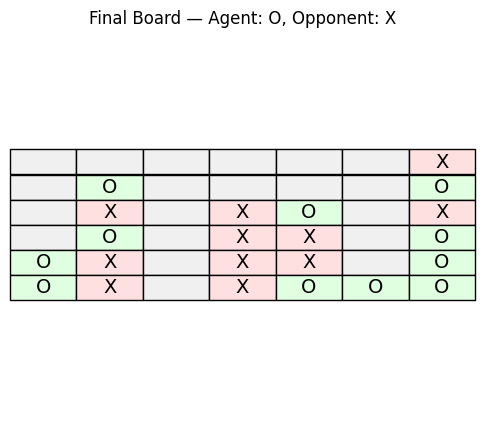

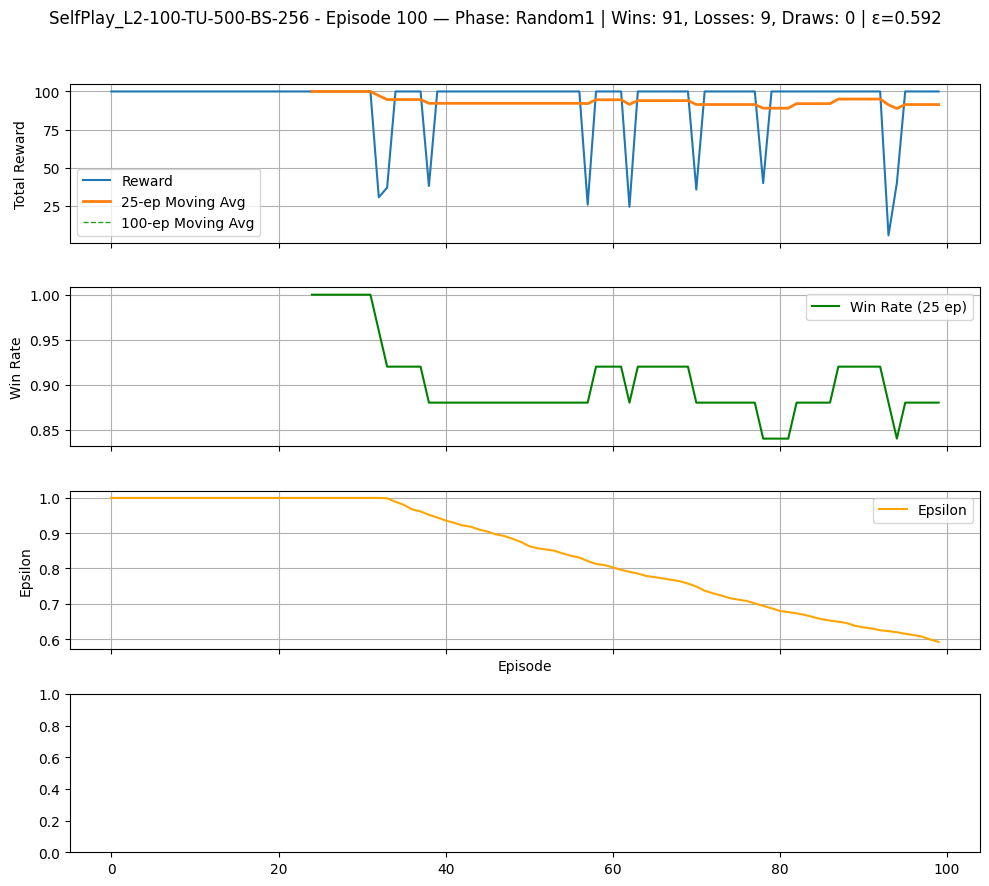

Training Episodes: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s, avg_reward=91.43, draws=0, epsilon=0.592, losses=9, phase=Random1, wins=91]


Training completed in 1.1 minutes (0.67 s/episode)
Win rate plot saved to Plots/DQN/DQN-SelfPlay_L2-100-TU-500-BS-256_final_winrate.png


In [7]:
summary_stats = {}  
env = Connect4Env()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)
agent = DQNAgent(device=device)

reward_history = []
win_history = []
epsilon_history = []
win_count = loss_count = draw_count = 0
phase = "Random"
strategy_weights = []
start_time = time.time()

with tqdm(total=num_episodes, desc="Training Episodes") as pbar:
    for episode in range(start_episode + 1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        done = False
        final_result = None  # 1 = win, -1 = loss, 0.5 = draw

        # Random start
        if random.random() < 0.5:
            opp_action = get_opponent_action(env, agent, episode, state, player=-1, depth=lookahead_depth)
            state, _, done = env.step(opp_action)

        while not done:
            valid_actions = env.available_actions()
            new_phase, strategy_weights, epsilon, memory_prune = get_phase(episode)    
            phase = handle_phase_change(agent, new_phase, phase,  epsilon, memory_prune)

            player_before_move = env.current_player  # <- track agent identity
            action = agent.act(state, valid_actions, player=env.current_player, depth=lookahead_depth, strategy_weights=strategy_weights)
            next_state, reward, done = env.step(action)

            if done:
                final_result = evaluate_final_result(env, player_before_move)
                agent.remember(state, action, reward, next_state, done)
                total_reward += reward
                
            else:
                opp_action = get_opponent_action(env, agent, episode, next_state, player=-1, depth=lookahead_depth)
                next_state, opp_reward, done = env.step(opp_action)
                if done:
                    final_result = evaluate_final_result(env, player_before_move)
                    total_reward += reward

                agent.remember(state, action, reward, next_state, done)

            agent.replay(batch_size)
            state = next_state
            #total_reward += reward

        epsilon_history.append(agent.epsilon)
        reward_history.append(total_reward)

        wins, losses, draws = track_result(final_result, win_history)
        win_count += wins
        loss_count += losses
        draw_count += draws

        if episode % target_update_interval == 0:
            agent.update_target_model()

        if episode % plot_interval == 0:
            avg_reward = np.mean(reward_history[-25:])
            pbar.set_postfix(avg_reward=f"{avg_reward:.2f}", epsilon=f"{agent.epsilon:.3f}",  wins=win_count, losses=loss_count,
                             draws=draw_count, phase=phase)

            clear_output(wait=True)
            
            if done: Connect4_BoardDisplayer.display_board(next_state)
            plot_live_training(episode, reward_history, win_history, epsilon_history, phase, win_count, loss_count, draw_count, TRAINING_SESSION, memory_prune)

        if episode % log_every_x_episode == 0:
            log_summary_stats(episode=episode,reward_history=reward_history,win_history=win_history,phase=phase,strategy_weights=strategy_weights,
                agent=agent,win_count=win_count,loss_count=loss_count,draw_count=draw_count,summary_stats_dict=summary_stats)

        pbar.update(1)

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes ({elapsed / num_episodes:.2f} s/episode)")

# --- Save final Win Rate plot ---
save_final_winrate_plot(win_history=win_history, training_phases=TRAINING_PHASES,save_path=PLOTS, session_name=TRAINING_SESSION)
print(f"Win rate plot saved to {PLOTS}DQN-{TRAINING_SESSION}_final_winrate.png")


In [8]:
print(f"\nSummary stats (every {log_every_x_episode} episodes):")
#pprint.pprint(summary_stats)
pd.DataFrame.from_dict(summary_stats, orient='index').to_excel(f"{LOG_DIR}DQN-{TRAINING_SESSION}-training_summary.xlsx", index=True)


Summary stats (every 100 episodes):


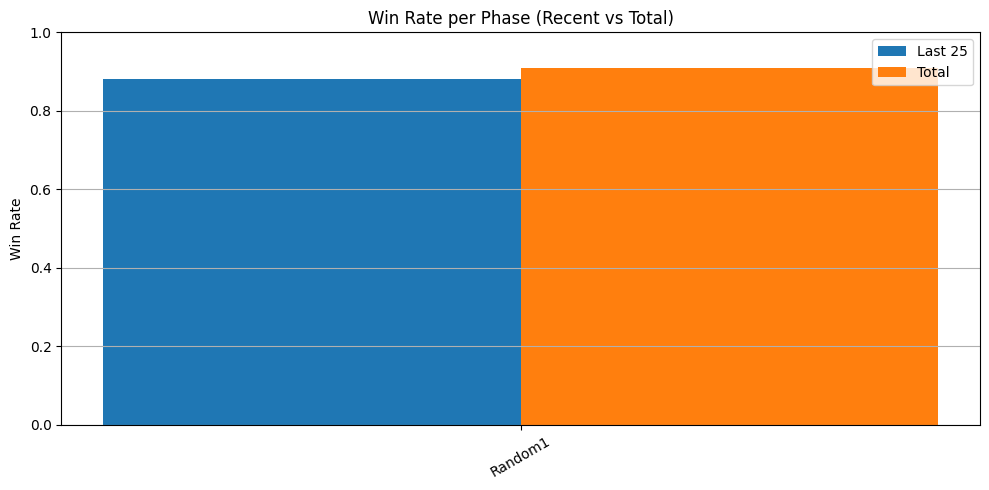

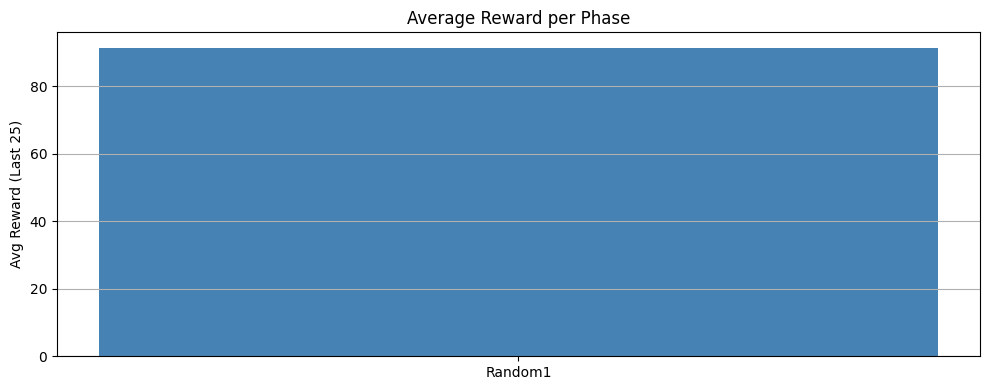

In [9]:
plot_phase_summary(summary_stats)

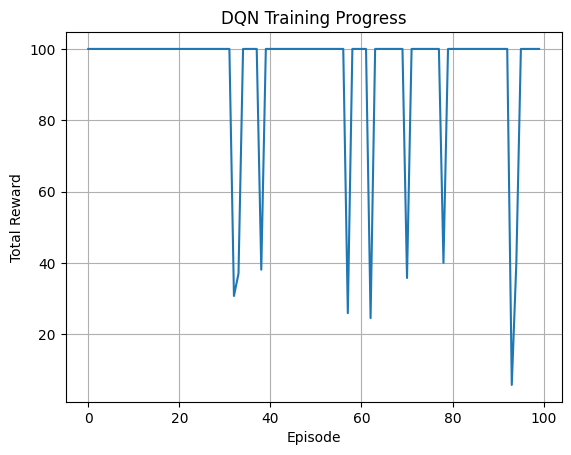

In [10]:
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Progress")
plt.grid(True)
plt.show()

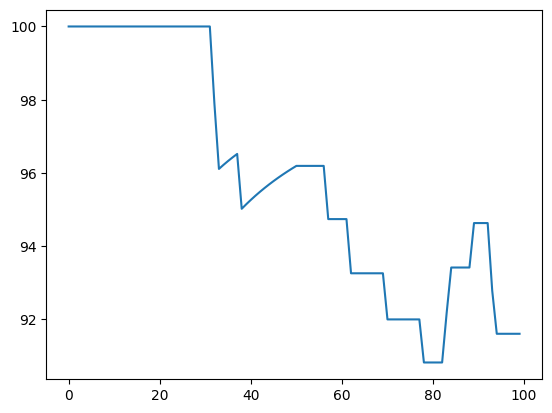

In [11]:
window = 50
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)
plt.show()

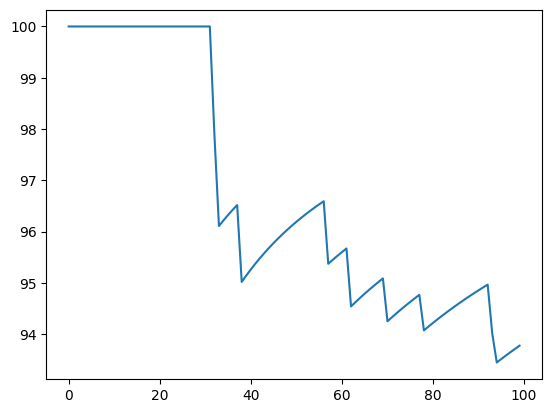

In [12]:
window = 250
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)
plt.show()

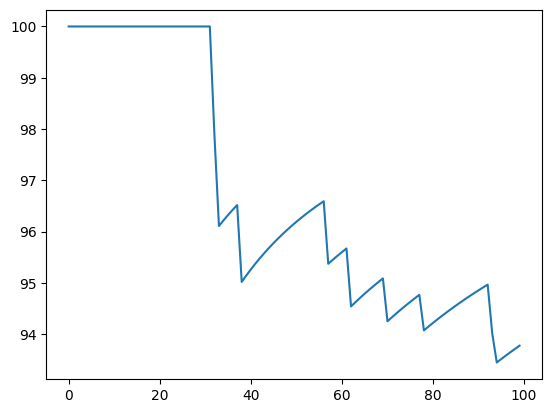

In [13]:
window = 1000
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)
plt.show()

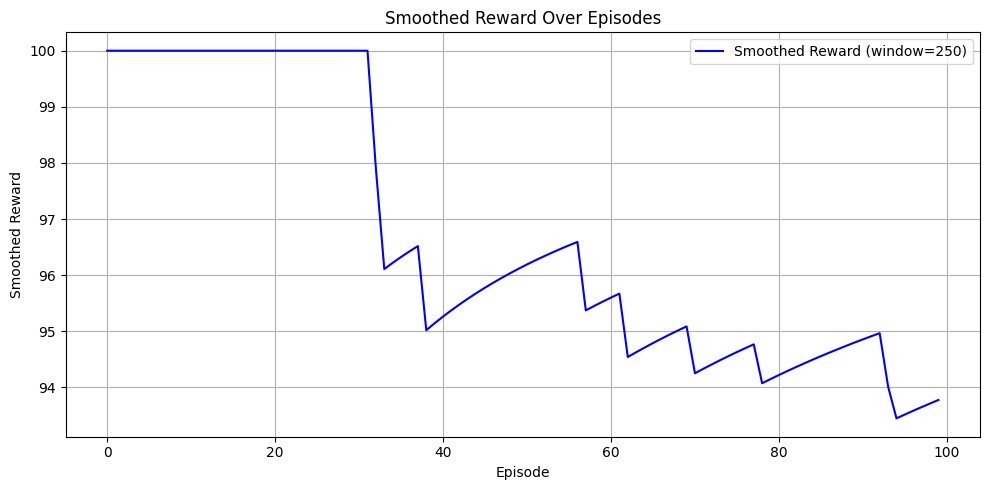

Smoothed reward plot saved to Plots/DQN/DQN-SelfPlay_L2-100-TU-500-BS-256_final_reward_smoothed.png


In [14]:
window = 250
smoothed = [np.mean(reward_history[max(0, i - window):i + 1]) for i in range(len(reward_history))]

final_reward_fig, final_reward_ax = plt.subplots(figsize=(10, 5))
final_reward_ax.plot(smoothed, label=f"Smoothed Reward (window={window})", color='blue')

# --- Add phase transitions ---
for name, meta in TRAINING_PHASES.items():
    ep = meta["length"]
    if ep is not None and ep <= len(reward_history):
        final_reward_ax.axvline(x=ep, color='black', linestyle='dotted', linewidth=1)
        final_reward_ax.text(ep + 5, max(smoothed) * 0.95, name,
                             rotation=90, va='top', ha='left', fontsize=8)

final_reward_ax.set_title("Smoothed Reward Over Episodes")
final_reward_ax.set_xlabel("Episode")
final_reward_ax.set_ylabel("Smoothed Reward")
final_reward_ax.legend()
final_reward_ax.grid(True)
final_reward_fig.tight_layout()

# --- Show plot ---
plt.show()

# --- Save to file ---
final_reward_fig.savefig(f"{PLOTS}DQN-{TRAINING_SESSION}_final_reward_smoothed.png")
plt.close(final_reward_fig)
print(f"Smoothed reward plot saved to {PLOTS}DQN-{TRAINING_SESSION}_final_reward_smoothed.png")


## Save model

In [15]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Connect4 dqn_model_{timestamp} episodes-{num_episodes} lookahead-{lookahead_depth}.pt"
default_model_path = "Connect4 DQN model.pt"

torch.save(agent.model.state_dict(), model_path)
torch.save(agent.model.state_dict(), default_model_path)
print(f"Model saved to {model_path}")


Model saved to Models/DQN/SelfPlay_L2-100-TU-500-BS-256_Connect4 dqn_model_20250809-195425 episodes-100 lookahead-7.pt


## Load model

In [16]:
agent = DQNAgent(device=device)  # Fresh agent instance
state_dict = torch.load(default_model_path, map_location=device, weights_only=True)
agent.model.load_state_dict(state_dict)
agent.update_target_model()
agent.epsilon = 0.0  # Fully greedy — no exploration
print("✅ Trained model loaded and ready for evaluation.")


✅ Trained model loaded and ready for evaluation.


# Evaluation

Opponent: Lookahead-3: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]

Evaluation completed in 1.1 minutes

📊 Evaluation Summary:
Random: 74W / 26L / 0D → Win Rate: 74.0%, Loss: 26.0%, Draws: 0.0%
Lookahead-1: 0W / 100L / 0D → Win Rate: 0.0%, Loss: 100.0%, Draws: 0.0%
Lookahead-2: 0W / 100L / 0D → Win Rate: 0.0%, Loss: 100.0%, Draws: 0.0%
Lookahead-3: 0W / 25L / 0D → Win Rate: 0.0%, Loss: 100.0%, Draws: 0.0%


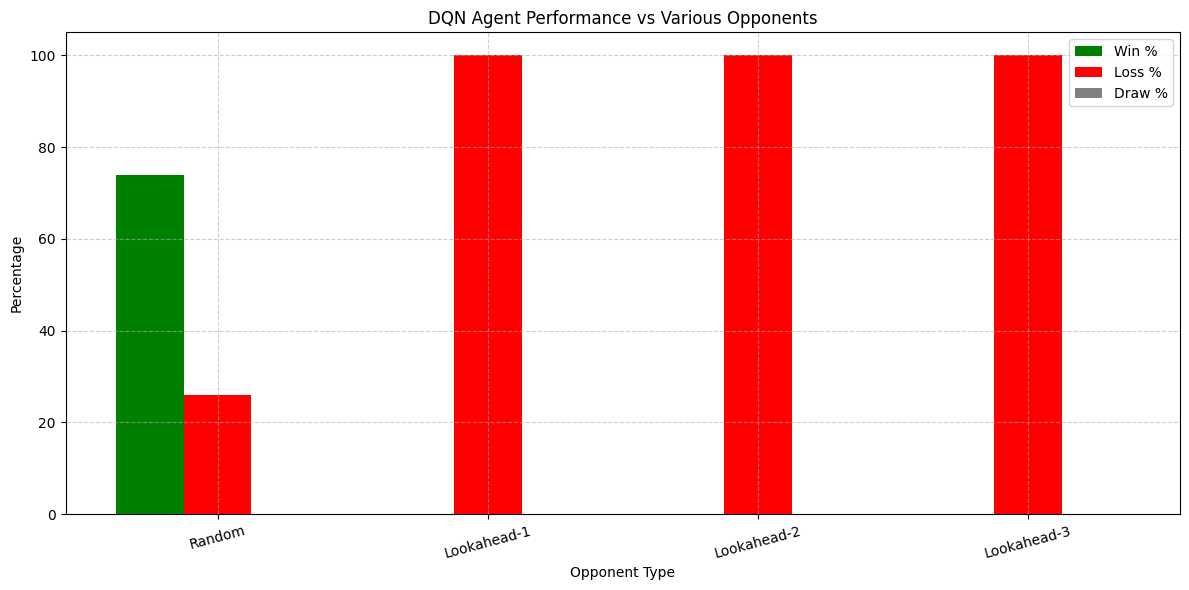

In [17]:
# === EVALUATION CONFIGURATION ===
evaluation_opponents = {
    "Random": 100,
    "Lookahead-1": 100,
    "Lookahead-2": 100,
    "Lookahead-3": 25,
    # "Lookahead-5": 10, # too soon to test
    # "Lookahead-7": 5  # too soon to test
}

# === Evaluation Loop ===
evaluation_results = {}

start_time = time.time()

for label, num_games in evaluation_opponents.items():
    wins = losses = draws = 0
    depth = int(label.split("-")[1]) if label.startswith("Lookahead") else None

    with tqdm(total=num_games, desc=f"Opponent: {label}") as pbar:
        for _ in range(num_games):
            state = env.reset()
            done = False
            agent_first = random.choice([True, False])

            while not done:
                if (env.current_player == 1 and agent_first) or (env.current_player == -1 and not agent_first):
                    valid_actions = env.available_actions()
                    action = agent.act(state, valid_actions, player=env.current_player, depth=lookahead_depth, strategy_weights=None)
                else:
                    if label == "Random":
                        action = random.choice(env.available_actions())
                    else:
                        board = np.array(state)
                        action = Lookahead.n_step_lookahead(board, env.current_player, depth=depth)
            
                state, reward, done = env.step(action)


            # Determine winner
            winner = -env.current_player
            if winner == 1:
                if agent_first:
                    wins += 1
                else:
                    losses += 1
            elif winner == -1:
                if not agent_first:
                    wins += 1
                else:
                    losses += 1
            else:
                draws += 1

            pbar.update(1)

    evaluation_results[label] = {
        "wins": wins,
        "losses": losses,
        "draws": draws,
        "win_rate": round(wins / num_games, 2),
        "loss_rate": round(losses / num_games, 2),
        "draw_rate": round(draws / num_games, 2)
    }


end_time = time.time()
elapsed = end_time - start_time
print(f"Evaluation completed in {elapsed/60:.1f} minutes")

# === Print Summary ===
print("\n📊 Evaluation Summary:")
for label, stats in evaluation_results.items():
    print(f"{label}: {stats['wins']}W / {stats['losses']}L / {stats['draws']}D → "
          f"Win Rate: {stats['win_rate']*100:.1f}%, Loss: {stats['loss_rate']*100:.1f}%, Draws: {stats['draw_rate']*100:.1f}%")

# === Bar Plot Summary ===
labels = list(evaluation_results.keys())
win_rates = [evaluation_results[k]['win_rate'] * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %', color='green')
plt.bar([i + bar_width for i in x], loss_rates, width=bar_width, label='Loss %', color='red')
plt.bar([i + 2 * bar_width for i in x], draw_rates, width=bar_width, label='Draw %', color='gray')

plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title('DQN Agent Performance vs Various Opponents')
plt.xticks([i + bar_width for i in x], labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Convert evaluation results to DataFrame
df_eval = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_eval.index.name = "Opponent"

# Save to CSV
df_eval.to_excel(f"{LOG_DIR}DQN-{TRAINING_SESSION}-evaluation_results.xlsx", index=True)


# DONE

In [18]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 0.0 hours


## Training log

In [19]:
# TRAINING_SESSION

training_log_file = "DQN training_sessions.xlsx"
log_row = {"TRAINING_SESSION": TRAINING_SESSION, "TIME [h]": total_elapsed, "EPISODES": num_episodes}

for label, stats in evaluation_results.items():
    log_row[label] = stats["win_rate"]

# === Load or Create Excel File ===
if os.path.exists(training_log_file):
    df_log = pd.read_excel(training_log_file)
else:
    df_log = pd.DataFrame()

# === Append and Save ===
df_log = pd.concat([df_log, pd.DataFrame([log_row])], ignore_index=True)
df_log.to_excel(training_log_file, index=False)

print(f"\n📁 Training session logged to: {training_log_file}")


📁 Training session logged to: DQN training_sessions.xlsx
